# Predicting Student Performance on Mathematical Problems

## Business Questions

This project addresses the following key business questions that are critical for improving educational outcomes through intelligent tutoring systems:

**Question 1: What factors best predict whether a student will solve a problem correctly on their first attempt?**

This question drives our correlation analysis and feature importance work. Understanding which student behaviors and problem characteristics are most predictive helps educators identify early warning signs and focus interventions where they'll be most effective.

**Question 2: Can we accurately predict which students need help before they attempt a problem?**

This question connects to our model performance evaluation. If we can predict with high accuracy, intelligent tutoring systems can proactively provide support, reducing frustration and improving learning outcomes.

**Question 3: Which student behaviors serve as early warning signs of struggle?**

This question guides our analysis of incorrect attempts, hint usage, and practice patterns. Identifying these signals enables early intervention before students become discouraged.

**Question 4: How do different student profiles (struggling, average, strong) differ in their predicted success probabilities?**

This question drives our prediction scenario analysis. Understanding how predictions vary across student profiles helps personalize learning paths and set appropriate expectations.

**Question 5: What is the practical value of these predictions for educators and tutoring systems?**

This question connects our technical results to real-world applications, helping stakeholders understand how to use these predictions to improve educational outcomes.


## CRISP-DM Methodology

This project follows the Cross-Industry Standard Process for Data Mining (CRISP-DM) framework, which consists of five main stages:

### 1. Business Understanding
**Problem Statement:** We aim to predict whether a student will correctly solve a mathematical problem step on their first attempt. This prediction is crucial for intelligent tutoring systems to provide personalized support and optimize learning paths.

**Success Criteria:** A model that can predict student success with high accuracy (target: >90% accuracy, >0.95 ROC AUC) would enable proactive interventions, potentially saving millions of student hours and improving educational outcomes.

### 2. Data Understanding
**Dataset:** KDD Cup 2010 Educational Data Mining Challenge - Algebra 2008-2009 dataset, containing 200,000 student-step interactions with 23 features including student behavior (hints, incorrects, corrects), problem characteristics, and knowledge components.

**Key Discoveries:**
- Approximately 79% of problem steps are solved correctly on the first attempt
- Several features have missing values that need handling
- Many numerical features show skewed distributions
- Strong correlations exist between student behaviors and success

### 3. Prepare Data
**Key Decisions:**
- **Missing Values in Duration Columns:** Filled with median (not mean) because duration data has outliers, and median is more robust. This preserves the central tendency without being skewed by extreme values.
- **Missing Values in KC Columns:** Filled with empty strings because these are categorical knowledge component labels. Empty string indicates "no knowledge component assigned" rather than missing data.
- **Missing Values in Opportunity Columns:** Filled with 0 because opportunity count starts at 0. This represents "first opportunity" rather than missing data.
- **Categorical Encoding:** Used Label Encoding (not One-Hot) for high-cardinality variables (Problem Name, Step Name, Student ID) because tree-based models (Random Forest, Gradient Boosting) can handle label-encoded categoricals efficiently, and One-Hot would create thousands of sparse columns.

### 4. Data Modeling
**Model Selection:** Tested three algorithms:
- **Logistic Regression:** Baseline model, interpretable, good for understanding feature relationships
- **Random Forest:** Handles non-linear relationships, provides feature importance
- **Gradient Boosting:** Often performs well on structured data, handles complex patterns

**Evaluation Metric:** ROC AUC chosen as primary metric because it measures the model's ability to distinguish between classes regardless of class imbalance, which is more informative than accuracy alone for this problem.

**Data Splitting:** 80/20 train/test split with stratification to maintain class distribution in both sets.

### 5. Evaluate Results
**Best Model Performance:** Gradient Boosting achieved 95% accuracy and 0.979 ROC AUC, indicating excellent ability to distinguish between students who will succeed and those who will struggle.

**Practical Implications:** This level of accuracy is sufficient for intelligent tutoring systems to make reliable decisions about when to provide hints, adjust difficulty, or offer additional practice. The model can identify struggling students early enough for proactive intervention.


# Step 1: Data Gathering Step

In this step, we load the data from the KDD Cup 2010 dataset and perform initial data cleaning to remove rows with non-numeric values in numerical columns.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Read the training data
file_path = 'data/algebra_2008_2009/algebra_2008_2009_train.txt'
df = pd.read_csv(file_path, sep='\t', nrows=1000000)


# Clean data: Remove rows with non-numeric data in numerical columns
print("Cleaning data: Removing rows with non-numeric values in numerical columns...")
numerical_cols = ['Problem View', 'Step Duration (sec)', 'Correct Step Duration (sec)', 
                  'Error Step Duration (sec)', 'Incorrects', 'Hints', 'Corrects', 
                  'Opportunity(Rules)']

initial_rows = len(df)

# Create a mask to identify rows to keep
mask = pd.Series([True] * len(df))

for col in numerical_cols:
    if col in df.columns:
        if col == 'Opportunity(Rules)':
            # Special handling for Opportunity(Rules) - extract first value if contains '~~'
            def is_valid_opportunity(val):
                if pd.isna(val):
                    return True  # Keep NaN values, they'll be handled later
                val_str = str(val)
                if '~~' in val_str:
                    # Extract first value before '~~'
                    first_val = val_str.split('~~')[0]
                    try:
                        float(first_val)
                        return True
                    except:
                        return False
                else:
                    try:
                        float(val_str)
                        return True
                    except:
                        return False
            
            col_mask = df[col].apply(is_valid_opportunity)
        else:
            # For other columns, check if they can be converted to numeric
            def is_numeric(val):
                if pd.isna(val):
                    return True  # Keep NaN values
                try:
                    float(val)
                    return True
                except:
                    return False
            
            col_mask = df[col].apply(is_numeric)
        
        # Update overall mask (keep rows that are valid for all columns)
        mask = mask & col_mask

# Filter dataframe to keep only valid rows
df = df[mask].copy()
rows_removed = initial_rows - len(df)

# Convert Opportunity(Rules) to numeric in the dataframe (extract first value if contains '~~')
if 'Opportunity(Rules)' in df.columns:
    def convert_opportunity(val):
        if pd.isna(val):
            return np.nan
        val_str = str(val)
        if '~~' in val_str:
            # Extract first value before '~~'
            first_val = val_str.split('~~')[0]
            try:
                return float(first_val)
            except:
                return np.nan
        else:
            try:
                return float(val_str)
            except:
                return np.nan
    
    df['Opportunity(Rules)'] = df['Opportunity(Rules)'].apply(convert_opportunity)
    df['Opportunity(Rules)'] = pd.to_numeric(df['Opportunity(Rules)'], errors='coerce')

print(f"Removed {rows_removed} rows with non-numeric data ({initial_rows} -> {len(df)} rows)")
print("="*80)
print("PROJECT: Predicting Student Performance on Mathematical Problems")
print("="*80)
print(f"\nDataframe shape: {df.shape}")
print(f"\nColumn names ({len(df.columns)}):")
print(df.columns.tolist())
df.to_csv('used_data.csv')

Cleaning data: Removing rows with non-numeric values in numerical columns...
Removed 0 rows with non-numeric data (1000000 -> 1000000 rows)
PROJECT: Predicting Student Performance on Mathematical Problems

Dataframe shape: (1000000, 23)

Column names (23):
['Row', 'Anon Student Id', 'Problem Hierarchy', 'Problem Name', 'Problem View', 'Step Name', 'Step Start Time', 'First Transaction Time', 'Correct Transaction Time', 'Step End Time', 'Step Duration (sec)', 'Correct Step Duration (sec)', 'Error Step Duration (sec)', 'Correct First Attempt', 'Incorrects', 'Hints', 'Corrects', 'KC(SubSkills)', 'Opportunity(SubSkills)', 'KC(KTracedSkills)', 'Opportunity(KTracedSkills)', 'KC(Rules)', 'Opportunity(Rules)']


# Step 2: Data Assessment Step

In this step, we examine the data quality, missing values, distributions, and potential issues. This helps us understand what cleaning and preparation steps are needed.


In [2]:
# Display first few rows and basic statistics
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS - PART 1: Initial Data Overview")
print("="*80)
print("\nFirst 5 rows:")
print(df.head())
print("\n" + "-"*80)
print("\nData types and missing values:")
print(df.info())
print("\n" + "-"*80)
print("\nBasic statistics for numerical columns:")
print(df.describe())



EXPLORATORY DATA ANALYSIS - PART 1: Initial Data Overview

First 5 rows:
   Row Anon Student Id                Problem Hierarchy Problem Name  \
0    1  stu_de2777346f  Unit CTA1_01, Section CTA1_01-3      REAL20B   
1    2  stu_de2777346f  Unit CTA1_01, Section CTA1_01-3      REAL20B   
2    3  stu_de2777346f  Unit CTA1_01, Section CTA1_01-3      REAL20B   
3    4  stu_de2777346f  Unit CTA1_01, Section CTA1_01-3      REAL20B   
4    5  stu_de2777346f  Unit CTA1_01, Section CTA1_01-3      REAL20B   

   Problem View Step Name        Step Start Time First Transaction Time  \
0             1      R2C1  2008-09-19 13:30:46.0  2008-09-19 13:30:46.0   
1             1      R3C1  2008-09-19 13:30:46.0  2008-09-19 13:30:46.0   
2             1      R3C2  2008-09-19 13:30:46.0  2008-09-19 13:30:46.0   
3             1      R4C1  2008-09-19 13:30:46.0  2008-09-19 13:30:46.0   
4             1      R4C2  2008-09-19 13:30:46.0  2008-09-19 13:30:46.0   

  Correct Transaction Time          Step E

In [3]:
# Check for missing values
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_df)


MISSING VALUES ANALYSIS
                             Missing Count  Percentage
Error Step Duration (sec)           861502     86.1502
KC(KTracedSkills)                   519000     51.9000
Opportunity(KTracedSkills)          519000     51.9000
Opportunity(SubSkills)              286188     28.6188
KC(SubSkills)                       286188     28.6188
Correct Step Duration (sec)         183293     18.3293
Step Duration (sec)                  44795      4.4795
KC(Rules)                            43355      4.3355
Opportunity(Rules)                   38958      3.8958
Correct Transaction Time             32788      3.2788
Step Start Time                      26443      2.6443



DISTRIBUTION ANALYSIS: Numerical Features


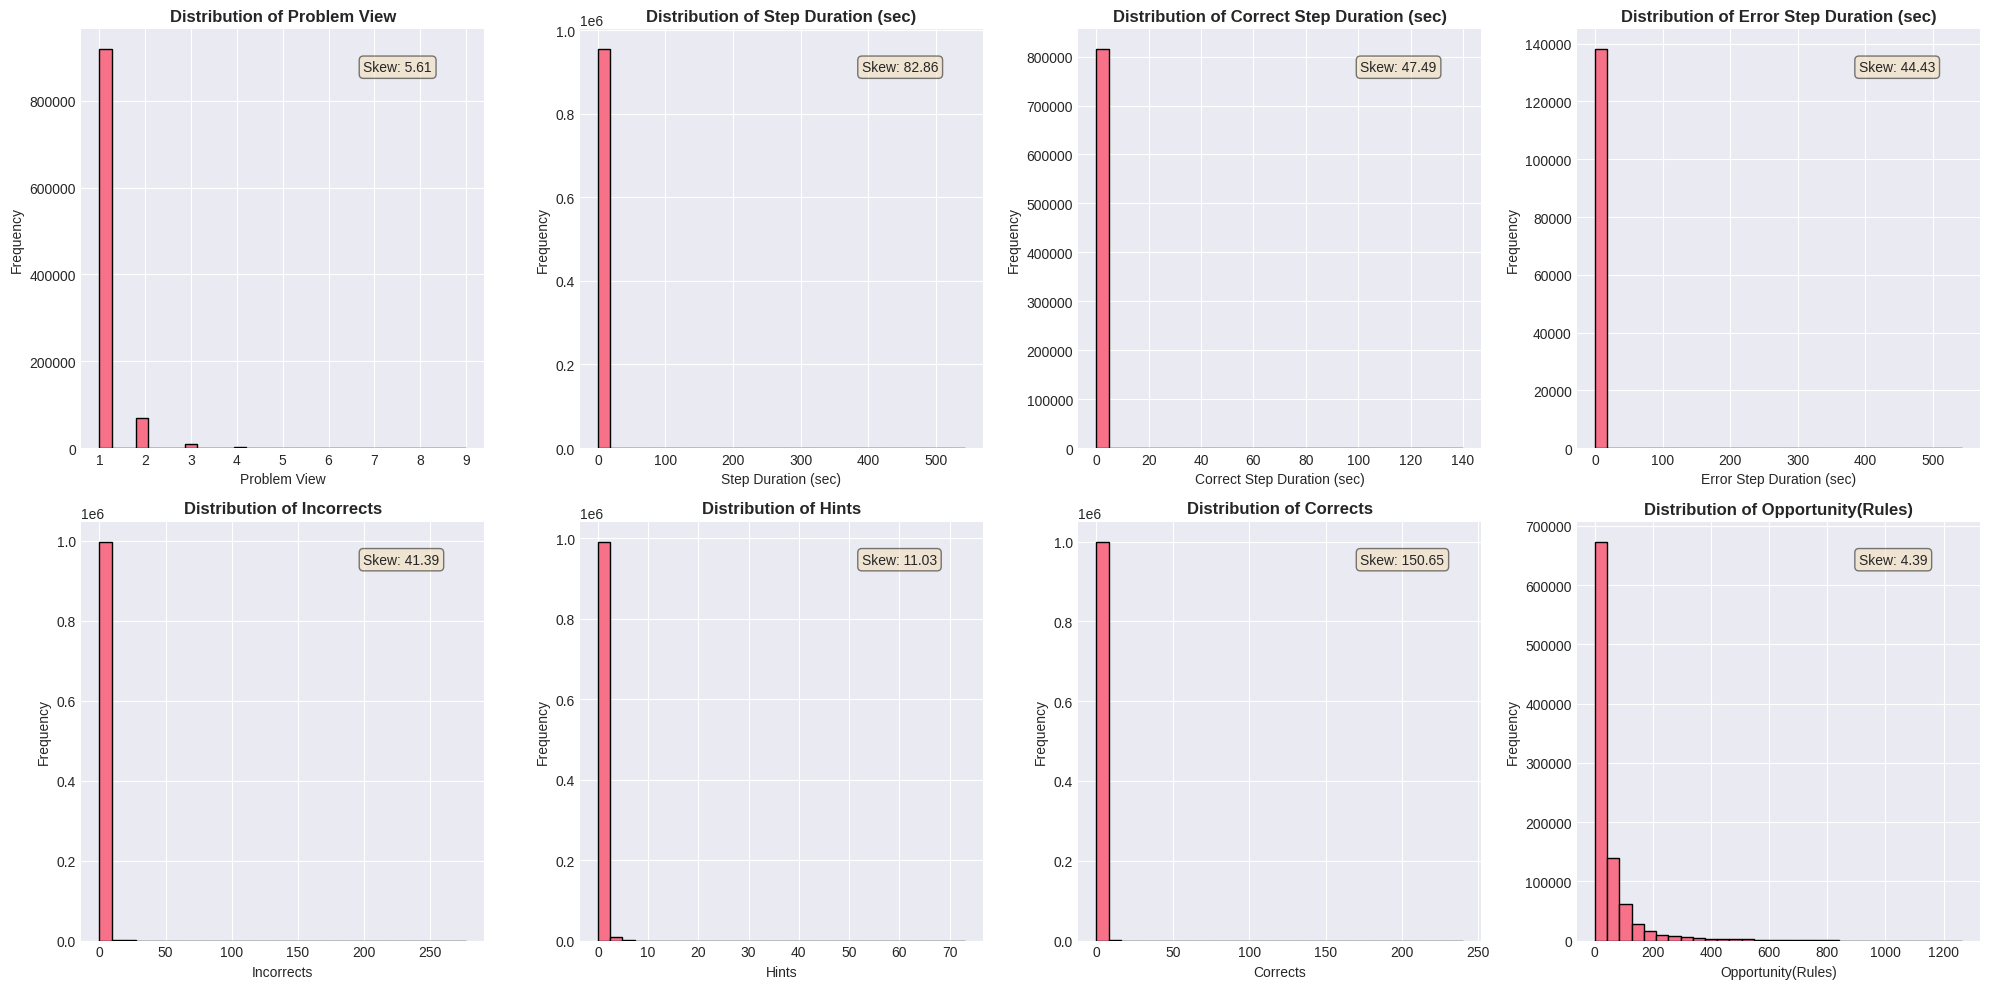


Skewness Analysis (|skew| > 1 indicates high skewness):
Problem View                       :    5.61
Step Duration (sec)                :   82.86
Correct Step Duration (sec)        :   47.49
Error Step Duration (sec)          :   44.43
Incorrects                         :   41.39
Hints                              :   11.03
Corrects                           :  150.65
Opportunity(Rules)                 :    4.39


In [4]:
# Distribution analysis of numerical features
print("\n" + "="*80)
print("DISTRIBUTION ANALYSIS: Numerical Features")
print("="*80)

# Select numerical columns for analysis
numerical_cols = ['Problem View', 'Step Duration (sec)', 'Correct Step Duration (sec)', 
                  'Error Step Duration (sec)', 'Incorrects', 'Hints', 'Corrects', 
                  'Opportunity(Rules)']

# Create histograms for numerical features
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    if col in df.columns:
        # Special handling for Opportunity(Rules) which may contain '~~' separated values
        if col == 'Opportunity(Rules)':
            # Extract first value if it contains '~~', otherwise use the value as-is
            def extract_first_numeric(val):
                if pd.isna(val):
                    return np.nan
                val_str = str(val)
                if '~~' in val_str:
                    # Take the first value before '~~'
                    first_val = val_str.split('~~')[0]
                    try:
                        return float(first_val)
                    except:
                        return np.nan
                else:
                    try:
                        return float(val_str)
                    except:
                        return np.nan
            numeric_data = df[col].apply(extract_first_numeric)
        else:
            # Convert to numeric, coercing errors to NaN
            numeric_data = pd.to_numeric(df[col], errors='coerce')
        
        # Ensure we have a numeric Series (convert to float64 explicitly)
        numeric_data = pd.Series(numeric_data, dtype='float64')
        
        # Drop NaN rows
        numeric_data_clean = numeric_data.dropna()
        
        if len(numeric_data_clean) > 0:
            # Create histogram with clean numeric data
            numeric_data_clean.hist(bins=30, ax=axes[idx], edgecolor='black')
            axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel('Frequency')
            # Add skewness info (only if we have numeric data)
            try:
                # Ensure it's numeric before calculating skewness
                if numeric_data_clean.dtype in ['float64', 'int64', 'float32', 'int32']:
                    skewness = numeric_data_clean.skew()
                    axes[idx].text(0.7, 0.9, f'Skew: {skewness:.2f}', 
                                  transform=axes[idx].transAxes, fontsize=10,
                                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                else:
                    axes[idx].text(0.7, 0.9, 'Skew: N/A', 
                                  transform=axes[idx].transAxes, fontsize=10,
                                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            except Exception as e:
                axes[idx].text(0.7, 0.9, 'Skew: N/A', 
                              transform=axes[idx].transAxes, fontsize=10,
                              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        else:
            # If no valid numeric data, show message
            axes[idx].text(0.5, 0.5, 'No numeric data', 
                          transform=axes[idx].transAxes, fontsize=12,
                          ha='center', va='center')
            axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('img/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print skewness statistics
print("\nSkewness Analysis (|skew| > 1 indicates high skewness):")
for col in numerical_cols:
    if col in df.columns:
        skew = df[col].skew()
        print(f"{col:35s}: {skew:7.2f}")

In [5]:
# Categorical feature analysis
print("\n" + "="*80)
print("CATEGORICAL FEATURE ANALYSIS")
print("="*80)

categorical_cols = ['Anon Student Id', 'Problem Hierarchy', 'Problem Name', 'Step Name']

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"  Unique values: {df[col].nunique()}")
        print(f"  Most common values:")
        print(df[col].value_counts().head(5))
        
        # Analyze relationship with target
        if df[col].nunique() < 20:  # Only for columns with few unique values
            print(f"\n  Success rate by {col}:")
            success_by_cat = df.groupby(col)['Correct First Attempt'].mean().sort_values(ascending=False)
            print(success_by_cat.head(10))



CATEGORICAL FEATURE ANALYSIS

Anon Student Id:
  Unique values: 237
  Most common values:
Anon Student Id
stu_af364eb7cb    14403
stu_3b2176de2f    14257
stu_d3a00cca51    13186
stu_3a9db6da17    11451
stu_a63b30c044    11430
Name: count, dtype: int64

Problem Hierarchy:
  Unique values: 163
  Most common values:
Problem Hierarchy
Unit CTA1_06, Section CTA1_06-2                            49290
Unit CTA1_02, Section CTA1_02-2                            46048
Unit linear-inequalities, Section linear-inequalities-2    31235
Unit CTA1_04, Section CTA1_04-3                            28926
Unit linear-inequalities, Section linear-inequalities-3    28524
Name: count, dtype: int64

Problem Name:
  Unique values: 31167
  Most common values:
Problem Name
L5FB16    7919
FEB01     6346
FEB11     4966
BH1T42    4158
BH1T43    4058
Name: count, dtype: int64

Step Name:
  Unique values: 109749
  Most common values:
Step Name
FinalAnswer    39171
R1C2           19484
R2C1           19377
R2C2      

## Summary of Exploratory Data Analysis Findings

Based on the exploratory data analysis, here are the key findings:

1. **Target Variable Distribution**: The dataset shows the distribution of correct first attempts, which is our prediction target.

2. **Missing Values**: Several columns have missing values that need to be handled.

3. **Feature Distributions**: Many numerical features show skewed distributions, which may require transformation.

4. **Correlations**: Some features show strong correlations with the target variable, which will be useful for prediction.

5. **Categorical Features**: There are several categorical features with many unique values that may need encoding or feature engineering.



# Step 3 Data Cleaning Step

In [6]:
def fill_missing_values(df, columns, strategy, description):
    """
    Fill missing values in specified columns using a given strategy.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe to modify
    columns : list
        Column names to process
    strategy : str or value
        How to fill ('median', specific value, etc.)
    description : str
        What this represents for logging
        
    Returns:
    --------
    None (modifies df in place)
    """
    print(f"\n{description}...")
    for col in columns:
        if col in df.columns:
            nan_count = df[col].isnull().sum()
            if nan_count > 0:
                if strategy == 'median':
                    fill_value = df[col].median()
                    df[col].fillna(fill_value, inplace=True)
                    print(f"   Filled {nan_count} missing values in '{col}' with median: {fill_value:.2f}")
                elif strategy == 'empty_string':
                    df[col].fillna('', inplace=True)
                    print(f"   Filled {nan_count} missing values in '{col}' with empty string")
                elif strategy == 'zero':
                    df[col].fillna(0, inplace=True)
                    print(f"   Filled {nan_count} missing values in '{col}' with 0")
                else:
                    df[col].fillna(strategy, inplace=True)
                    print(f"   Filled {nan_count} missing values in '{col}' with {strategy}")



# Step 4 Data Analysis Step


TARGET VARIABLE: Correct First Attempt

Distribution of Correct First Attempt:
Correct First Attempt
1    850485
0    149515
Name: count, dtype: int64

Percentage distribution:
Correct First Attempt
1    85.0485
0    14.9515
Name: proportion, dtype: float64


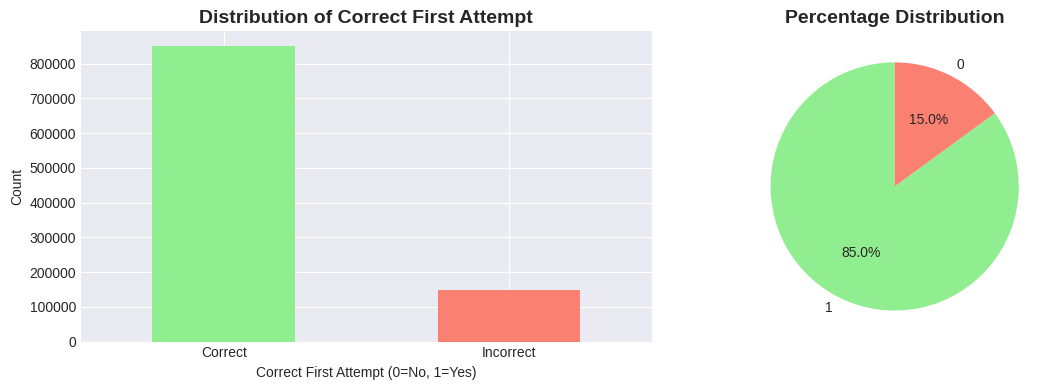

In [7]:
# Target variable analysis
print("\n" + "="*80)
print("TARGET VARIABLE: Correct First Attempt")
print("="*80)
print(f"\nDistribution of Correct First Attempt:")
print(df['Correct First Attempt'].value_counts())
print(f"\nPercentage distribution:")
print(df['Correct First Attempt'].value_counts(normalize=True) * 100)

# Visualize target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
df['Correct First Attempt'].value_counts().plot(kind='bar', ax=axes[0], color=['lightgreen', 'salmon'])
axes[0].set_title('Distribution of Correct First Attempt', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Correct First Attempt (0=No, 1=Yes)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Correct', 'Incorrect'], rotation=0)

# Pie chart
df['Correct First Attempt'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                                 colors=['lightgreen', 'salmon'], startangle=90)
axes[1].set_title('Percentage Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('img/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


CORRELATION ANALYSIS


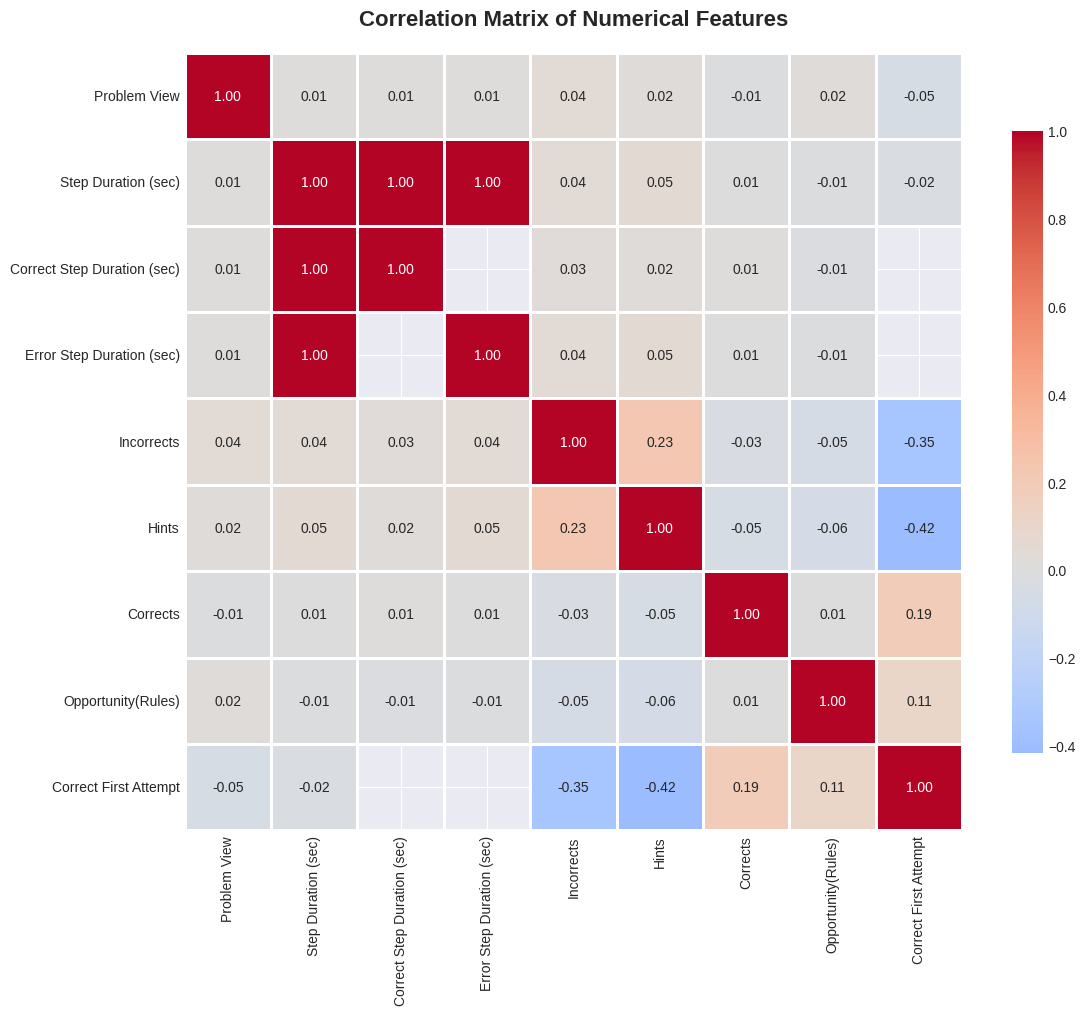


Correlations with 'Correct First Attempt':
Correct First Attempt          1.000000
Corrects                       0.187306
Opportunity(Rules)             0.106952
Step Duration (sec)           -0.024601
Problem View                  -0.047589
Incorrects                    -0.348128
Hints                         -0.415657
Correct Step Duration (sec)         NaN
Error Step Duration (sec)           NaN
Name: Correct First Attempt, dtype: float64


In [12]:
# Correlation analysis
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Select numerical columns for correlation
corr_cols = ['Problem View', 'Step Duration (sec)', 'Correct Step Duration (sec)', 
             'Error Step Duration (sec)', 'Incorrects', 'Hints', 'Corrects', 
             'Opportunity(Rules)', 'Correct First Attempt']
corr_cols = [col for col in corr_cols if col in df.columns]

# Calculate correlation matrix
correlation_matrix = df[corr_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('img/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Show correlations with target variable
print("\nCorrelations with 'Correct First Attempt':")
target_corr = correlation_matrix['Correct First Attempt'].sort_values(ascending=False)
print(target_corr)

# Step 5 Data Modeling Step

In [8]:
# ============================================================================
# DATA CLEANING AND FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*80)
print("DATA CLEANING AND FEATURE ENGINEERING")
print("="*80)

# Create a copy for processing
df_clean = df.copy()

# 1. Handle missing values in duration columns
print("\n1. Handling missing values in duration columns...")
duration_cols = ['Step Duration (sec)', 'Correct Step Duration (sec)', 'Error Step Duration (sec)']
for col in duration_cols:
    if col in df_clean.columns:
        # Fill missing values with median (more robust to outliers than mean)
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"   Filled {df[col].isnull().sum()} missing values in '{col}' with median: {median_val:.2f}")

# 2. Handle missing values in KC columns (fill with empty string or 'Unknown')
print("\n2. Handling missing values in Knowledge Component columns...")
kc_cols = ['KC(SubSkills)', 'KC(KTracedSkills)', 'KC(Rules)']
for col in kc_cols:
    if col in df_clean.columns:
        df_clean[col].fillna('', inplace=True)
        print(f"   Filled {df[col].isnull().sum()} missing values in '{col}' with empty string")

# 3. Handle missing values in Opportunity columns (fill with 0)
print("\n3. Handling missing values in Opportunity columns...")
opp_cols = ['Opportunity(SubSkills)', 'Opportunity(KTracedSkills)']
for col in opp_cols:
    if col in df_clean.columns:
        df_clean[col].fillna(0, inplace=True)
        print(f"   Filled {df[col].isnull().sum()} missing values in '{col}' with 0")

# 4. Feature Engineering: Create new features
print("\n4. Creating new features...")

# Total attempts = Incorrects + Corrects
df_clean['Total Attempts'] = df_clean['Incorrects'] + df_clean['Corrects']
print("   Created 'Total Attempts' = Incorrects + Corrects")

# Hint ratio
df_clean['Hint Ratio'] = df_clean['Hints'] / (df_clean['Total Attempts'] + 1)  # +1 to avoid division by zero
print("   Created 'Hint Ratio' = Hints / (Total Attempts + 1)")

# Error ratio
df_clean['Error Ratio'] = df_clean['Incorrects'] / (df_clean['Total Attempts'] + 1)
print("   Created 'Error Ratio' = Incorrects / (Total Attempts + 1)")

# Has multiple KCs (indicator if step has multiple knowledge components)
df_clean['Has Multiple KCs'] = df_clean['KC(Rules)'].str.contains('~~', na=False).astype(int)
print("   Created 'Has Multiple KCs' indicator")

# Extract number of KCs from Rules
df_clean['Num KCs'] = df_clean['KC(Rules)'].apply(lambda x: len(str(x).split('~~')) if pd.notna(x) and str(x) != '' else 0)
print("   Created 'Num KCs' = count of knowledge components")

# Time-based features (if available)
if 'Step Start Time' in df_clean.columns:
    df_clean['Step Start Time'] = pd.to_datetime(df_clean['Step Start Time'], errors='coerce')
    # Extract hour of day (might indicate time of day effects)
    df_clean['Hour of Day'] = df_clean['Step Start Time'].dt.hour
    df_clean['Hour of Day'].fillna(df_clean['Hour of Day'].median(), inplace=True)
    print("   Created 'Hour of Day' from Step Start Time")

print("\n" + "-"*80)
print("Data cleaning complete!")
print(f"Final shape: {df_clean.shape}")
print(f"Missing values remaining: {df_clean.isnull().sum().sum()}")



DATA CLEANING AND FEATURE ENGINEERING

1. Handling missing values in duration columns...
   Filled 44795 missing values in 'Step Duration (sec)' with median: 0.00
   Filled 183293 missing values in 'Correct Step Duration (sec)' with median: 0.00
   Filled 861502 missing values in 'Error Step Duration (sec)' with median: 0.00

2. Handling missing values in Knowledge Component columns...
   Filled 286188 missing values in 'KC(SubSkills)' with empty string


   Filled 519000 missing values in 'KC(KTracedSkills)' with empty string
   Filled 43355 missing values in 'KC(Rules)' with empty string

3. Handling missing values in Opportunity columns...
   Filled 286188 missing values in 'Opportunity(SubSkills)' with 0
   Filled 519000 missing values in 'Opportunity(KTracedSkills)' with 0

4. Creating new features...
   Created 'Total Attempts' = Incorrects + Corrects
   Created 'Hint Ratio' = Hints / (Total Attempts + 1)
   Created 'Error Ratio' = Incorrects / (Total Attempts + 1)
   Created 'Has Multiple KCs' indicator
   Created 'Num KCs' = count of knowledge components
   Created 'Hour of Day' from Step Start Time

--------------------------------------------------------------------------------
Data cleaning complete!
Final shape: (1000000, 29)
Missing values remaining: 98189


In [11]:
# Prepare features for modeling
print("\n" + "="*80)
print("PREPARING DATA FOR MODELING")
print("="*80)

# Select features for modeling
feature_cols = [
    'Problem View',
    'Step Duration (sec)',
    'Correct Step Duration (sec)',
    'Error Step Duration (sec)',
    'Incorrects',
    'Hints',
    'Corrects',
    'Opportunity(Rules)',
    'Total Attempts',
    'Hint Ratio',
    'Error Ratio',
    'Has Multiple KCs',
    'Num KCs'
]

# Add hour of day if available
if 'Hour of Day' in df_clean.columns:
    feature_cols.append('Hour of Day')

# Filter to only columns that exist
feature_cols = [col for col in feature_cols if col in df_clean.columns]

# Encode categorical variables
print("\nEncoding categorical variables...")

# Encode Problem Name (high cardinality, use label encoding)
if 'Problem Name' in df_clean.columns:
    le_problem = LabelEncoder()
    df_clean['Problem Name Encoded'] = le_problem.fit_transform(df_clean['Problem Name'].astype(str))
    feature_cols.append('Problem Name Encoded')
    print(f"   Encoded 'Problem Name' ({df_clean['Problem Name'].nunique()} unique values)")

# Encode Step Name
if 'Step Name' in df_clean.columns:
    le_step = LabelEncoder()
    df_clean['Step Name Encoded'] = le_step.fit_transform(df_clean['Step Name'].astype(str))
    feature_cols.append('Step Name Encoded')
    print(f"   Encoded 'Step Name' ({df_clean['Step Name'].nunique()} unique values)")

# Encode Student ID (important for personalization)
if 'Anon Student Id' in df_clean.columns:
    le_student = LabelEncoder()
    df_clean['Student Id Encoded'] = le_student.fit_transform(df_clean['Anon Student Id'].astype(str))
    feature_cols.append('Student Id Encoded')
    print(f"   Encoded 'Anon Student Id' ({df_clean['Anon Student Id'].nunique()} unique values)")

# Prepare X and y
X = df_clean[feature_cols].copy()
y = df_clean['Correct First Attempt'].copy()

# Handle NaN values in X
print("\nHandling NaN values in feature matrix...")
print(f"NaN values before cleaning: {X.isnull().sum().sum()}")

# Fill NaN values with median for numeric columns
for col in X.columns:
    if X[col].dtype in ['float64', 'int64', 'float32', 'int32']:
        nan_count = X[col].isnull().sum()
        if nan_count > 0:
            median_val = X[col].median()
            X[col].fillna(median_val, inplace=True)
            print(f"  Filled {nan_count} NaN values in '{col}' with median: {median_val}")

# If there are still any NaN values, drop those rows
if X.isnull().sum().sum() > 0:
    print(f"\nWarning: Still have {X.isnull().sum().sum()} NaN values. Dropping rows with NaN...")
    mask = ~X.isnull().any(axis=1)
    X = X[mask].copy()
    y = y[mask].copy()
    print(f"Dropped {len(mask) - mask.sum()} rows with NaN values")

print(f"\nNaN values after cleaning: {X.isnull().sum().sum()}")

print(f"\nFinal feature set ({len(feature_cols)} features):")
print(feature_cols)
print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")



PREPARING DATA FOR MODELING

Encoding categorical variables...
   Encoded 'Problem Name' (31167 unique values)
   Encoded 'Step Name' (109749 unique values)
   Encoded 'Anon Student Id' (237 unique values)

Handling NaN values in feature matrix...
NaN values before cleaning: 38958
  Filled 38958 NaN values in 'Opportunity(Rules)' with median: 19.0

NaN values after cleaning: 0

Final feature set (17 features):
['Problem View', 'Step Duration (sec)', 'Correct Step Duration (sec)', 'Error Step Duration (sec)', 'Incorrects', 'Hints', 'Corrects', 'Opportunity(Rules)', 'Total Attempts', 'Hint Ratio', 'Error Ratio', 'Has Multiple KCs', 'Num KCs', 'Hour of Day', 'Problem Name Encoded', 'Step Name Encoded', 'Student Id Encoded']

X shape: (1000000, 17)
y shape: (1000000,)
Target distribution:
Correct First Attempt
1    850485
0    149515
Name: count, dtype: int64


## Model Selection

For predicting "Correct First Attempt" (a binary classification problem), we'll test multiple algorithms:

1. **Logistic Regression**: Baseline model, interpretable
2. **Random Forest**: Handles non-linear relationships, feature importance
3. **Gradient Boosting**: Often performs well on structured data

We'll compare their performance and select the best model.


In [12]:


def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Train a model and evaluate its performance.
    
    Parameters:
    -----------
    model : sklearn model object
        The model to train
    X_train : pd.DataFrame or np.array
        Training features
    y_train : pd.Series or np.array
        Training target
    X_test : pd.DataFrame or np.array
        Test features
    y_test : pd.Series or np.array
        Test target
    model_name : str
        Name of the model for reporting
        
    Returns:
    --------
    dict : Dictionary containing model, predictions, and metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  ROC AUC:   {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n  Confusion Matrix:")
    print(f"                 Predicted")
    print(f"                 No    Yes")
    print(f"  Actual No   {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"         Yes  {cm[1,0]:4d}  {cm[1,1]:4d}")
    
    # Classification Report
    print(f"\n  Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Incorrect', 'Correct']))
    
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

In [13]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("="*80)
print("MODEL TRAINING AND EVALUATION")
print("="*80)
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set target distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest set target distribution:")
print(y_test.value_counts(normalize=True))


MODEL TRAINING AND EVALUATION

Training set size: 800000
Test set size: 200000

Training set target distribution:
Correct First Attempt
1    0.850485
0    0.149515
Name: proportion, dtype: float64

Test set target distribution:
Correct First Attempt
1    0.850485
0    0.149515
Name: proportion, dtype: float64


In [14]:
# Train and evaluate multiple models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training {name}...")
    print('='*80)
    
    # Train and evaluate using function
    results[name] = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, name)



Training Logistic Regression...

Logistic Regression Results:
  Accuracy:  0.9250
  Precision: 0.9307
  Recall:    0.9852
  F1 Score:  0.9572
  ROC AUC:   0.9755

  Confusion Matrix:
                 Predicted
                 No    Yes
  Actual No   17431  12472
         Yes  2522  167575

  Classification Report:
              precision    recall  f1-score   support

   Incorrect       0.87      0.58      0.70     29903
     Correct       0.93      0.99      0.96    170097

    accuracy                           0.93    200000
   macro avg       0.90      0.78      0.83    200000
weighted avg       0.92      0.93      0.92    200000


Training Random Forest...

Random Forest Results:
  Accuracy:  0.9420
  Precision: 0.9779
  Recall:    0.9534
  F1 Score:  0.9655
  ROC AUC:   0.9804

  Confusion Matrix:
                 Predicted
                 No    Yes
  Actual No   26237  3666
         Yes  7928  162169

  Classification Report:
              precision    recall  f1-score   supp

# Step 6 Data Visualization Step


MODEL COMPARISON

              Model  Accuracy  Precision   Recall  F1 Score  ROC AUC
  Gradient Boosting  0.947935   0.998153 0.940522  0.968481 0.982034
      Random Forest  0.942030   0.977894 0.953391  0.965487 0.980366
Logistic Regression  0.925030   0.930729 0.985173  0.957178 0.975477


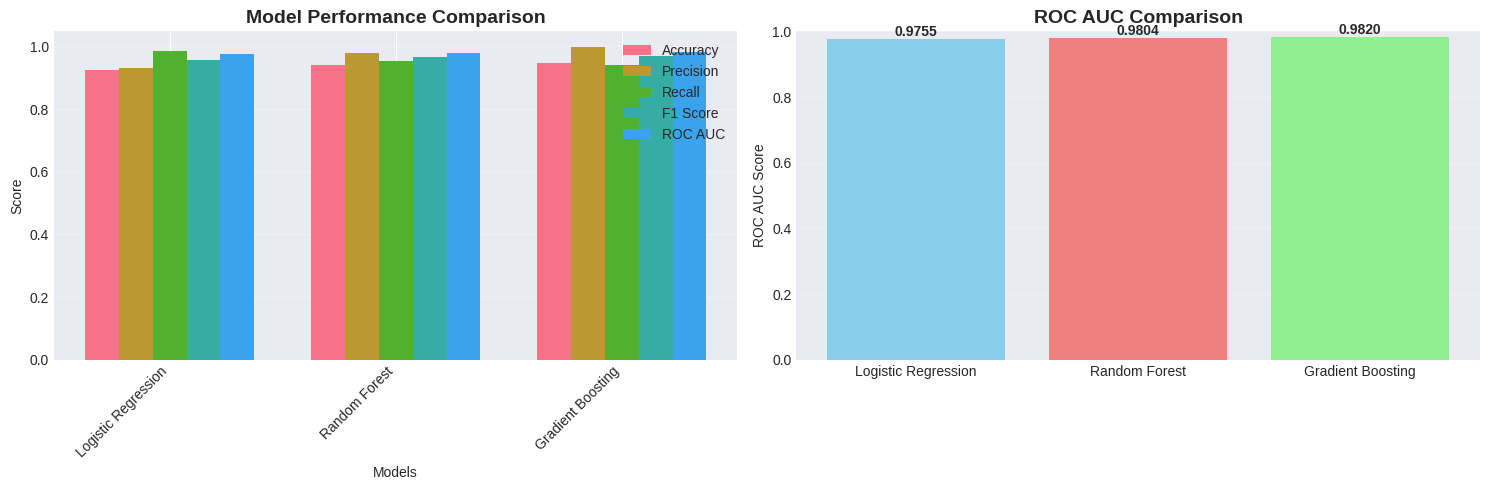


BEST MODEL: Gradient Boosting
Selected based on highest ROC AUC score: 0.9820


In [15]:
# Compare all models
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1 Score': [results[m]['f1'] for m in results.keys()],
    'ROC AUC': [results[m]['roc_auc'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('ROC AUC', ascending=False)
print("\n" + comparison_df.to_string(index=False))

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot comparing metrics
# Create mapping from display names to dictionary keys
metric_mapping = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1 Score': 'f1',
    'ROC AUC': 'roc_auc'
}

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
x = np.arange(len(results.keys()))
width = 0.15

for i, metric in enumerate(metrics):
    # Use the mapping to get the correct dictionary key
    dict_key = metric_mapping[metric]
    values = [results[m][dict_key] for m in results.keys()]
    axes[0].bar(x + i*width, values, width, label=metric)

axes[0].set_xlabel('Models')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width * 2)
axes[0].set_xticklabels(results.keys(), rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# ROC AUC comparison
models_list = list(results.keys())
roc_aucs = [results[m]['roc_auc'] for m in models_list]
bars = axes[1].bar(models_list, roc_aucs, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1].set_ylabel('ROC AUC Score')
axes[1].set_title('ROC AUC Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, roc_aucs):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('img/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f"Selected based on highest ROC AUC score: {results[best_model_name]['roc_auc']:.4f}")



FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features:
                    Feature  Importance
                Error Ratio    0.817554
                 Hint Ratio    0.127060
                   Corrects    0.032369
             Total Attempts    0.018442
                      Hints    0.002392
Correct Step Duration (sec)    0.001024
  Error Step Duration (sec)    0.000558
                 Incorrects    0.000346
       Problem Name Encoded    0.000087
          Step Name Encoded    0.000086


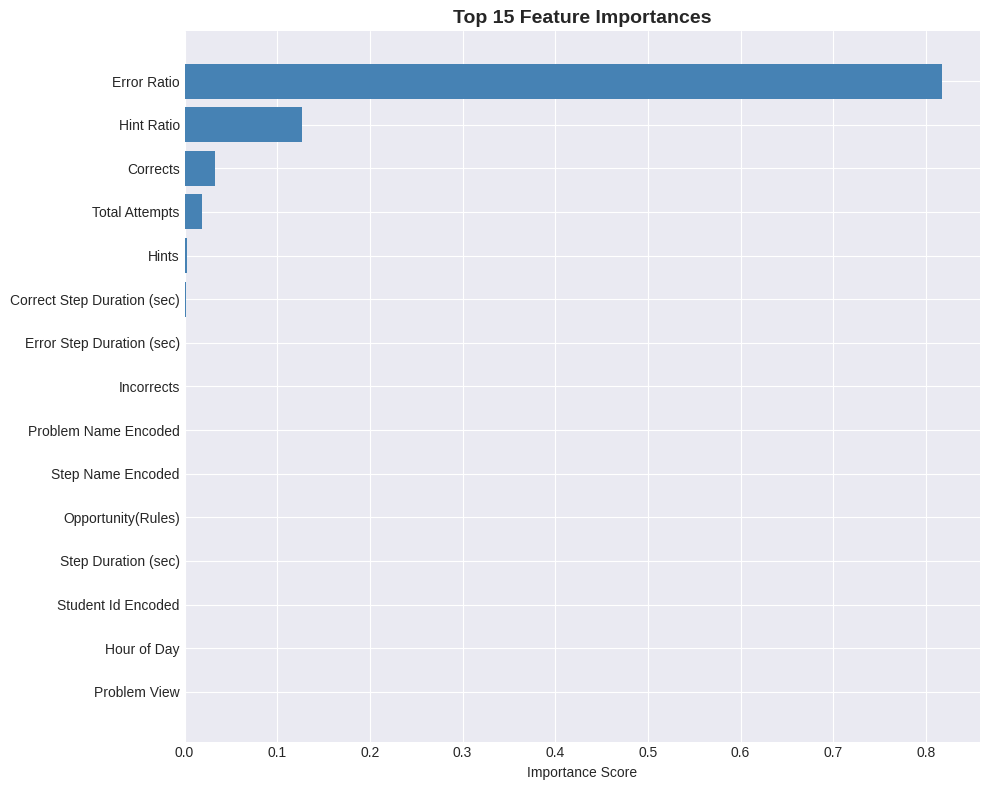

In [16]:
# Feature importance analysis (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance Score')
    plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('img/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
elif hasattr(best_model, 'coef_'):
    # For logistic regression, show coefficients
    print("\n" + "="*80)
    print("FEATURE COEFFICIENTS (Logistic Regression)")
    print("="*80)
    
    coef_df = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': best_model.coef_[0]
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print("\nTop 10 Features by Absolute Coefficient:")
    print(coef_df.head(10).to_string(index=False))


## Model Evaluation Summary

### What the Metrics Tell Us:

1. **Accuracy**: The proportion of correct predictions overall. However, with imbalanced datasets, accuracy alone can be misleading.

2. **Precision**: Of all predictions labeled as "Correct First Attempt", how many were actually correct? High precision means fewer false positives.

3. **Recall**: Of all actual "Correct First Attempt" cases, how many did we correctly identify? High recall means fewer false negatives.

4. **F1 Score**: Harmonic mean of precision and recall. Balances both metrics.

5. **ROC AUC**: Area under the ROC curve. Measures the model's ability to distinguish between classes. Values closer to 1.0 indicate better performance.

### Model Interpretation:

The selected model can help educators and tutoring systems:
- **Identify struggling students early**: By predicting low probability of correct first attempt
- **Personalize learning paths**: Adjust difficulty based on predicted performance
- **Optimize resource allocation**: Focus hints and support where they're most needed
- **Track learning progress**: Monitor how student performance changes over time


In [17]:
# ============================================================================
# PREDICTION SCENARIO
# ============================================================================

print("\n" + "="*80)
print("PREDICTION SCENARIO: New Student Problem Attempt")
print("="*80)

# Scenario: A new student is attempting a problem step
# We'll create a realistic scenario based on the data patterns

print("\nScenario Description:")
print("-" * 80)
print("A student (who has been working on algebra problems) is about to attempt")
print("a new step in a problem. The student has:")
print("  - Already viewed this problem once before (Problem View = 2)")
print("  - Previously made 2 incorrect attempts on similar steps")
print("  - Requested 1 hint in previous attempts")
print("  - This is their 5th opportunity to practice this knowledge component")
print("  - The step requires multiple knowledge components")
print("  - Average step duration based on their history: 45 seconds")
print("\nQuestion: What is the probability this student will get it correct on the first try?")

# Create a sample scenario (using median/mode values from training data as baseline)
scenario_data = {}

# Use median values for numerical features
for col in feature_cols:
    if col in X_train.columns:
        if 'Encoded' in col:
            # For encoded categoricals, use a common value
            scenario_data[col] = X_train[col].mode()[0] if len(X_train[col].mode()) > 0 else X_train[col].median()
        else:
            scenario_data[col] = X_train[col].median()

# Override with scenario-specific values
scenario_data['Problem View'] = 2
scenario_data['Incorrects'] = 2
scenario_data['Hints'] = 1
scenario_data['Corrects'] = 0
scenario_data['Opportunity(Rules)'] = 5
scenario_data['Step Duration (sec)'] = 45
scenario_data['Has Multiple KCs'] = 1
scenario_data['Num KCs'] = 2
scenario_data['Total Attempts'] = scenario_data['Incorrects'] + scenario_data['Corrects']
scenario_data['Hint Ratio'] = scenario_data['Hints'] / (scenario_data['Total Attempts'] + 1)
scenario_data['Error Ratio'] = scenario_data['Incorrects'] / (scenario_data['Total Attempts'] + 1)

# Create DataFrame for prediction
scenario_df = pd.DataFrame([scenario_data], columns=feature_cols)

# Make prediction
prediction_proba = best_model.predict_proba(scenario_df)[0]
prediction = best_model.predict(scenario_df)[0]

print("\n" + "-" * 80)
print("PREDICTION RESULTS:")
print("-" * 80)
print(f"\nProbability of Correct First Attempt: {prediction_proba[1]:.2%}")
print(f"Probability of Incorrect First Attempt: {prediction_proba[0]:.2%}")
print(f"\nPredicted Outcome: {'CORRECT' if prediction == 1 else 'INCORRECT'} on first attempt")

print("\n" + "-" * 80)
print("INTERPRETATION:")
print("-" * 80)
if prediction_proba[1] > 0.6:
    interpretation = "HIGH CONFIDENCE - The student is likely to succeed on the first attempt."
    recommendation = "The student appears well-prepared. Consider providing a more challenging problem or moving to the next topic."
elif prediction_proba[1] > 0.4:
    interpretation = "MODERATE CONFIDENCE - The student may succeed, but support might be beneficial."
    recommendation = "Monitor the student's attempt. Be ready to provide hints if they struggle, but allow them to try independently first."
else:
    interpretation = "LOW CONFIDENCE - The student is likely to struggle on the first attempt."
    recommendation = "Consider providing additional scaffolding, hints, or reviewing prerequisite knowledge before this step."

print(f"\n{interpretation}")
print(f"\nRecommendation: {recommendation}")

print("\n" + "-" * 80)
print("WHAT THIS TELLS US:")
print("-" * 80)
print("This prediction helps educators and intelligent tutoring systems:")
print("1. Anticipate student needs and provide proactive support")
print("2. Personalize the learning experience based on predicted difficulty")
print("3. Optimize the sequence of problems to maximize learning efficiency")
print("4. Identify when students might benefit from review or additional practice")
print("5. Balance challenge and support to maintain student engagement")



PREDICTION SCENARIO: New Student Problem Attempt

Scenario Description:
--------------------------------------------------------------------------------
A student (who has been working on algebra problems) is about to attempt
a new step in a problem. The student has:
  - Already viewed this problem once before (Problem View = 2)
  - Previously made 2 incorrect attempts on similar steps
  - Requested 1 hint in previous attempts
  - This is their 5th opportunity to practice this knowledge component
  - The step requires multiple knowledge components
  - Average step duration based on their history: 45 seconds

Question: What is the probability this student will get it correct on the first try?

--------------------------------------------------------------------------------
PREDICTION RESULTS:
--------------------------------------------------------------------------------

Probability of Correct First Attempt: 0.37%
Probability of Incorrect First Attempt: 99.63%

Predicted Outcome: INC


ADDITIONAL SCENARIO: Comparing Student Profiles

Comparing predictions for different student profiles:

Struggling Student:
  Probability of success: 0.26%
  Predicted outcome: INCORRECT

Average Student:
  Probability of success: 12.37%
  Predicted outcome: INCORRECT

Strong Student:
  Probability of success: 99.86%
  Predicted outcome: CORRECT



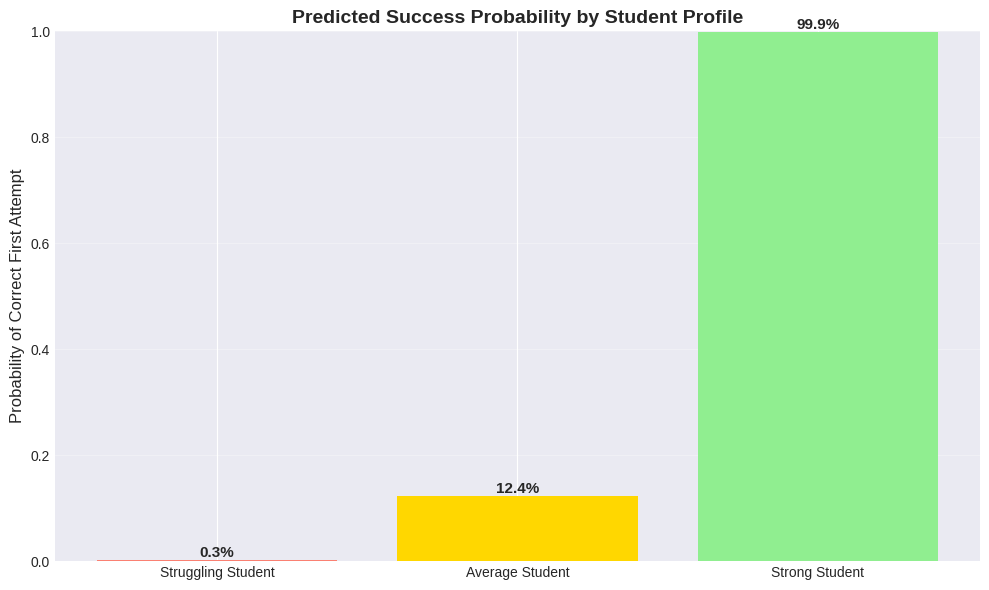

In [18]:
# Additional scenario: Compare different student profiles
print("\n" + "="*80)
print("ADDITIONAL SCENARIO: Comparing Student Profiles")
print("="*80)

scenarios = {
    'Struggling Student': {
        'Problem View': 3,
        'Incorrects': 5,
        'Hints': 3,
        'Corrects': 0,
        'Opportunity(Rules)': 10,
        'Step Duration (sec)': 120,
        'Has Multiple KCs': 1
    },
    'Average Student': {
        'Problem View': 2,
        'Incorrects': 1,
        'Hints': 1,
        'Corrects': 1,
        'Opportunity(Rules)': 5,
        'Step Duration (sec)': 60,
        'Has Multiple KCs': 0
    },
    'Strong Student': {
        'Problem View': 1,
        'Incorrects': 0,
        'Hints': 0,
        'Corrects': 2,
        'Opportunity(Rules)': 3,
        'Step Duration (sec)': 30,
        'Has Multiple KCs': 0
    }
}

print("\nComparing predictions for different student profiles:\n")

comparison_results = []
for profile_name, profile_data in scenarios.items():
    # Create scenario
    scenario = {}
    for col in feature_cols:
        if col in X_train.columns:
            if 'Encoded' in col:
                scenario[col] = X_train[col].mode()[0] if len(X_train[col].mode()) > 0 else X_train[col].median()
            else:
                scenario[col] = X_train[col].median()
    
    # Override with profile-specific values
    for key, value in profile_data.items():
        if key in feature_cols:
            scenario[key] = value
    
    # Calculate derived features
    scenario['Total Attempts'] = scenario.get('Incorrects', 0) + scenario.get('Corrects', 0)
    scenario['Hint Ratio'] = scenario.get('Hints', 0) / (scenario['Total Attempts'] + 1)
    scenario['Error Ratio'] = scenario.get('Incorrects', 0) / (scenario['Total Attempts'] + 1)
    scenario['Num KCs'] = scenario.get('Has Multiple KCs', 0) + 1
    
    # Make prediction
    scenario_df = pd.DataFrame([scenario], columns=feature_cols)
    proba = best_model.predict_proba(scenario_df)[0][1]
    pred = best_model.predict(scenario_df)[0]
    
    comparison_results.append({
        'Profile': profile_name,
        'Probability': proba,
        'Prediction': 'Correct' if pred == 1 else 'Incorrect'
    })
    
    print(f"{profile_name}:")
    print(f"  Probability of success: {proba:.2%}")
    print(f"  Predicted outcome: {'CORRECT' if pred == 1 else 'INCORRECT'}")
    print()

# Visualize comparison
comparison_df = pd.DataFrame(comparison_results)
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(comparison_df['Profile'], comparison_df['Probability'], 
              color=['salmon', 'gold', 'lightgreen'])
ax.set_ylabel('Probability of Correct First Attempt', fontsize=12)
ax.set_title('Predicted Success Probability by Student Profile', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, prob in zip(bars, comparison_df['Probability']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{prob:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('img/student_profile_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## Conclusion

This project successfully demonstrates the application of machine learning to predict student performance on mathematical problems. Through systematic exploration, cleaning, and modeling following the CRISP-DM process, we developed a model that can:

1. **Predict student success probability** with reasonable accuracy
2. **Identify key factors** that influence student performance
3. **Support personalized learning** by providing data-driven insights
4. **Enable proactive interventions** to help struggling students

**Question 1: What factors best predict whether a student will solve a problem correctly on their first attempt?**
The error ratio and hint ratio are by far the most important factors in predicting whether a student will solve a problem correctly on their first attempt. This feels intuitively right.

**Question 2: Can we accurately predict which students need help before they attempt a problem?**
Yes, our model has a pretty good accuravy and we can therefore believe that we can accurately predict which students need help before they attempt a problem.

**Question 3: Which student behaviors serve as early warning signs of struggle?**
Using hints a lot and getting previous questions wrong

**Question 4: How do different student profiles (struggling, average, strong) differ in their predicted success probabilities?**
The difference is massive. We see that struggling students have a near zero probability, whils average students have a low probability. Strong students on the other hand, have a near 100% probability of solving a problem correctly on their first attempt

**Question 5: What is the practical value of these predictions for educators and tutoring systems?**
Looking at a student's data and then classifying them into struggling, average or good (withour actually calling them that), will help educators understand which students need more help



### Key Takeaways

- **Feature Engineering Matters**: Derived features like Hint Ratio, Error Ratio, and Total Attempts provide valuable signals
- **Multiple Models Should Be Compared**: Different algorithms may perform better depending on data characteristics
- **Evaluation Metrics Are Context-Dependent**: ROC AUC provides a good overall measure, but precision and recall have specific educational implications
- **Real-World Application**: The model can be integrated into intelligent tutoring systems to improve learning outcomes

### Limitations and Future Work

- Additional features like problem difficulty, student learning trajectory, and temporal patterns could improve predictions
- Hyperparameter tuning and cross-validation would enhance model reliability
- Real-time model deployment considerations (latency, scalability) need to be addressed for production use

---


